# Importing Libraries

In [77]:
import os

%matplotlib inline
import matplotlib.pyplot as plt #visualization
import numpy as np #mathematical computations
import pandas as pd # read and manipulate dataset
import os
from glob import glob
import seaborn as sns
from PIL import Image
np.random.seed(50) 
from sklearn.preprocessing import StandardScaler #to normalize or standardize the data 
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV
from sklearn.metrics import accuracy_score
import itertools

import keras
from keras.utils.np_utils import to_categorical # used for converting labels to one-hot-encoding
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras import backend as K
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.optimizers import Adam, RMSprop
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau
from keras.wrappers.scikit_learn import KerasClassifier
from keras.applications.inception_v3 import InceptionV3
from keras import backend as K 
import random
import urllib.request
import matplotlib.image as mpimg

from skimage.filters import rank, threshold_otsu #To manipulate Images
from skimage import io
from skimage.color import rgb2gray
from sklearn.cluster import KMeans
from skimage.morphology import closing, square, disk

# Loading Data

In [78]:
# Train image
train='/kaggle/input/skin-cancer-malignant-vs-benign/train'
# test image
test='/kaggle/input/skin-cancer-malignant-vs-benign/test'

## Data Collection

In [79]:
# Here we have two class.
dataset_path_train = os.listdir(train)
print (dataset_path_train)
print("Types of classes labels found: ", len(dataset_path_train))

['benign', 'malignant']
Types of classes labels found:  2


In [80]:
# Extract the label  for every image
class_labels = []

for item in dataset_path_train: 
 #
 all_classes = os.listdir(train + '/' +item+'/')
 # Add them to the list
 for room in all_classes:
    class_labels.append((item, str('dataset_path' + '/' +item) + '/' + room))

In [81]:
# Creat DataFrame for training images and labels
df_train = pd.DataFrame(data=class_labels, columns=['Labels', 'image'])
df_train.head()

Labels                         image
0  benign   dataset_path/benign/764.jpg
1  benign  dataset_path/benign/1700.jpg
2  benign  dataset_path/benign/1786.jpg
3  benign  dataset_path/benign/1075.jpg
4  benign   dataset_path/benign/771.jpg

In [82]:
print("Total number of images in the dataset: ", len(df_train))
print("Here we have count of class in kind of image.")
label_count = df_train['Labels'].value_counts()
print(label_count)

Total number of images in the dataset:  2637
Here we have count of class in kind of image.
benign       1440
malignant    1197
Name: Labels, dtype: int64


## PREPROCESSING

In [83]:
import cv2
path = '/kaggle/input/skin-cancer-malignant-vs-benign/train/'
dataset_path = os.listdir('/kaggle/input/skin-cancer-malignant-vs-benign/train/')

im_size =224

images = []
labels = []

for i in dataset_path:
    data_path = path + str(i)  
    filenames = [i for i in os.listdir(data_path) ]
   ## Append label names accordingly
    for f in filenames:
        img = cv2.imread(data_path + '/' + f)
        img = cv2.resize(img, (im_size, im_size))
        images.append(img)
        labels.append(i)

In [84]:
## converting python list into numpy array
images = np.array(images)
images = images.astype('float32') / 255.0
print("Shape of Image :", images.shape)

Shape of Image : (2637, 224, 224, 3)


In [85]:
from sklearn.preprocessing import LabelEncoder , OneHotEncoder
y=df_train['Labels'].values
print(y)

y_labelencoder = LabelEncoder ()
y = y_labelencoder.fit_transform(y)

['benign' 'benign' 'benign' ... 'malignant' 'malignant' 'malignant']


In [14]:
y

array([0, 0, 0, ..., 1, 1, 1])

In [86]:
y=y.reshape(-1,1)
from sklearn.compose import ColumnTransformer
ct = ColumnTransformer([('my_ohe', OneHotEncoder(), [0])], remainder='passthrough')
Y = ct.fit_transform(y) #.toarray()

print("The Label After convert it to hotencoding:")
print(Y[:5])
print(Y[35:])

The Label After convert it to hotencoding:
[[1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]]
[[1. 0.]
 [1. 0.]
 [1. 0.]
 ...
 [0. 1.]
 [0. 1.]
 [0. 1.]]


In [87]:
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split


images, Y = shuffle(images, Y, random_state=42)


train_x, test_x, train_y, test_y = train_test_split(images, Y, test_size=0.1, random_state=42)

#inspect the shape of the training and testing.
print("Shape of X train data:",train_x.shape)
print("Shape of Y train",train_y.shape)

Shape of X train data: (2373, 224, 224, 3)
Shape of Y train (2373, 2)


In [88]:
s1 = np.arange(train_x.shape[0])
np.random.shuffle(s1)
X_train = train_x[s1]
y_train = train_y[s1]

s2 = np.arange(test_x.shape[0])
np.random.shuffle(s2)
X_test = test_x[s2]
y_test = test_y[s2] 

In [89]:
print("Shuffle orders example: ", s1)
print("Shape of train is:",X_train.shape)
print("Shape of train is:",y_train.shape)

Shuffle orders example:  [1906 1038 1651 ... 1931 1504 1712]
Shape of train is: (2373, 224, 224, 3)
Shape of train is: (2373, 2)


# Model Construction

In [90]:
from tensorflow import keras
from tensorflow.keras.datasets import mnist
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.layers import Dense, Activation, SimpleRNN
from tensorflow.keras.layers import Flatten, concatenate
from PIL import Image as Img

In [91]:
# Size Of Image
image_size = X_train.shape[1]
print("The Shape of image :",image_size)

The Shape of image : 224


In [92]:
# compute the number of labels
num_labels = len(np.unique(y_train))
print("Number Of Labels:",num_labels)

Number Of Labels: 2


In [93]:
# Network parameters
# Image is processed as is (square grayscale)
input_shape = (image_size, image_size, 3)
batch_size = 128
kernel_size = 3
pool_size = 2
filters = 64
dropout = 0.5

# Creat Model CNN 

In [94]:
# Model is a stack of CNN-ReLU-MaxPooling
model = Sequential()

model.add(Conv2D(filters=filters,kernel_size=kernel_size, activation='relu', input_shape=input_shape))

model.add(MaxPooling2D(pool_size))
model.add(Conv2D(filters=filters, kernel_size=kernel_size, activation='relu'))

model.add(MaxPooling2D(pool_size))
model.add(Conv2D(filters=filters,kernel_size=kernel_size,activation='relu'))

model.add(Flatten())

# dropout added as regularizer
model.add(Dropout(dropout))
# output layer is 10-dim one-hot vector
model.add(Dense(num_labels))
model.add(Activation('softmax'))


In [95]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 222, 222, 64)      1792      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 111, 111, 64)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 109, 109, 64)      36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 54, 54, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 52, 52, 64)        36928     
_________________________________________________________________
flatten_1 (Flatten)          (None, 173056)            0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 173056)           

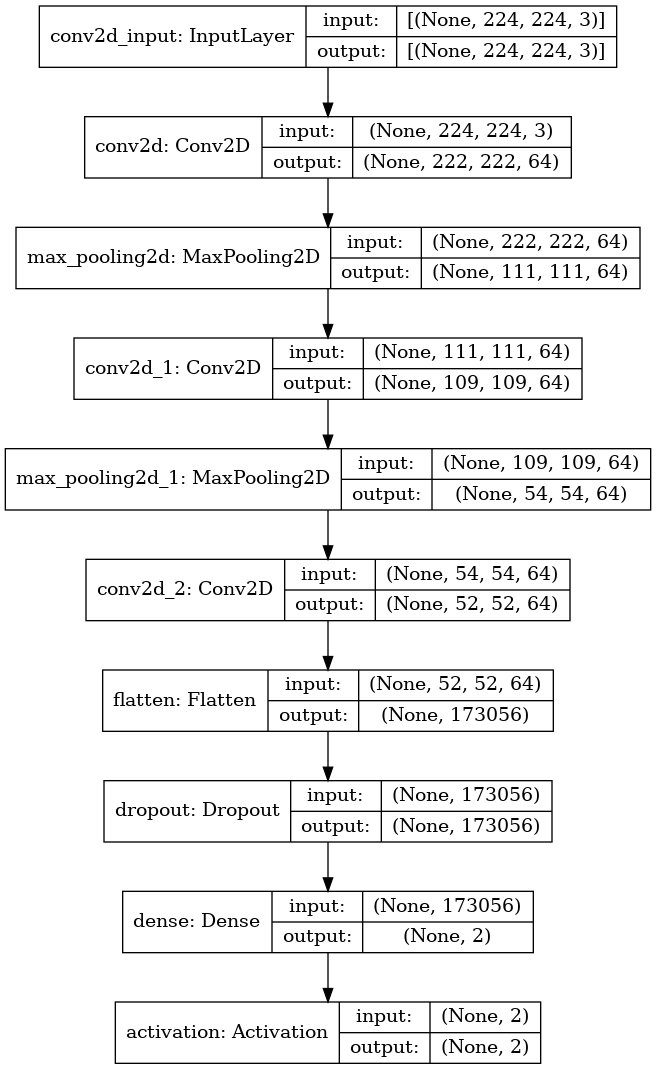

In [24]:
from tensorflow.keras.utils import to_categorical, plot_model
plot_model(model, to_file='CNN_Skin_Cancer_Image.png', show_shapes=True)

In [97]:
import tensorflow as tf
import tensorflow_addons as tfa
from tensorflow.keras import metrics
from tensorflow_addons.metrics import F1Score
from tensorflow.keras.optimizers import Adam
from tensorflow_addons.metrics import MatthewsCorrelationCoefficient
metrics = ['accuracy']

lr=0.001
model.compile(optimizer = Adam(learning_rate = 0.001), loss = "binary_crossentropy", metrics = metrics)

In [98]:
# train the network
history =model.fit(X_train, y_train, epochs=60, batch_size=batch_size,
                   callbacks = [EarlyStopping(monitor="val_loss",
                                              patience=4,restore_best_weights=True), 
                                ReduceLROnPlateau(patience=2)])

2023-01-21 23:15:09.909327: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 1428811776 exceeds 10% of free system memory.
2023-01-21 23:15:11.589382: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 1428811776 exceeds 10% of free system memory.


Epoch 1/60
19/19 [==============================] - 5s 176ms/step - loss: 0.9034 - accuracy: 0.5402
Epoch 2/60
19/19 [==============================] - 3s 132ms/step - loss: 0.5690 - accuracy: 0.6987
Epoch 3/60
19/19 [==============================] - 3s 139ms/step - loss: 0.5275 - accuracy: 0.7155
Epoch 4/60
19/19 [==============================] - 3s 146ms/step - loss: 0.4956 - accuracy: 0.7421
Epoch 5/60
19/19 [==============================] - 3s 133ms/step - loss: 0.4744 - accuracy: 0.7623
Epoch 6/60
19/19 [==============================] - 3s 133ms/step - loss: 0.4327 - accuracy: 0.7762
Epoch 7/60
19/19 [==============================] - 3s 136ms/step - loss: 0.4126 - accuracy: 0.7956
Epoch 8/60
19/19 [==============================] - 3s 134ms/step - loss: 0.4069 - accuracy: 0.8003
Epoch 9/60
19/19 [==============================] - 3s 135ms/step - loss: 0.3900 - accuracy: 0.8074
Epoch 10/60
19/19 [==============================] - 3s 133ms/step - loss: 0.3861 - accuracy: 0.8104

dict_keys(['loss', 'accuracy', 'lr'])


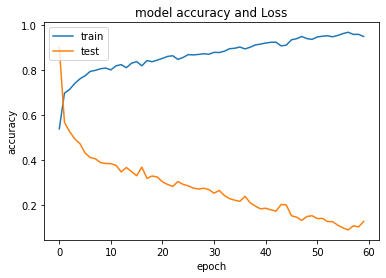

In [99]:
# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['loss'])
plt.title('model accuracy and Loss')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')###Test here is still validation
plt.show()

# Evaluate The Model

In [152]:
Evaluations_CNN= model.evaluate(X_test,y_test)#Real X_test and y_test
Evaluations_CNN

9/9 [==============================] - 0s 14ms/step - loss: 0.7368 - accuracy: 0.8030


[0.7368090748786926, 0.8030303120613098]

### Save Model

In [101]:
model.save('CNN_Model2.h5')

## Make Prediction 

In [105]:
from sklearn.metrics import classification_report
Y_pred = model.predict(X_test,y_test.all())
y_pred = np.argmax(Y_pred, axis=1)
y_actual = np.argmax(y_test, axis=1)

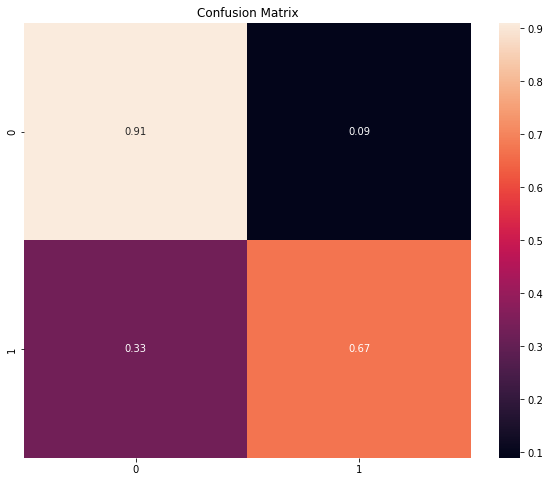

In [103]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
cf = confusion_matrix(y_actual, y_pred, normalize = "true")
plt.figure(figsize=(10, 8))
sns.heatmap(cf, annot=True, xticklabels = sorted(set(y_actual)), yticklabels = sorted(set(y_actual)))
plt.title('Confusion Matrix')
plt.show()

In [106]:
print("The predict lable:",list(y_pred))

The predict lable: [0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0]


##  Predictions on randomly selected test images

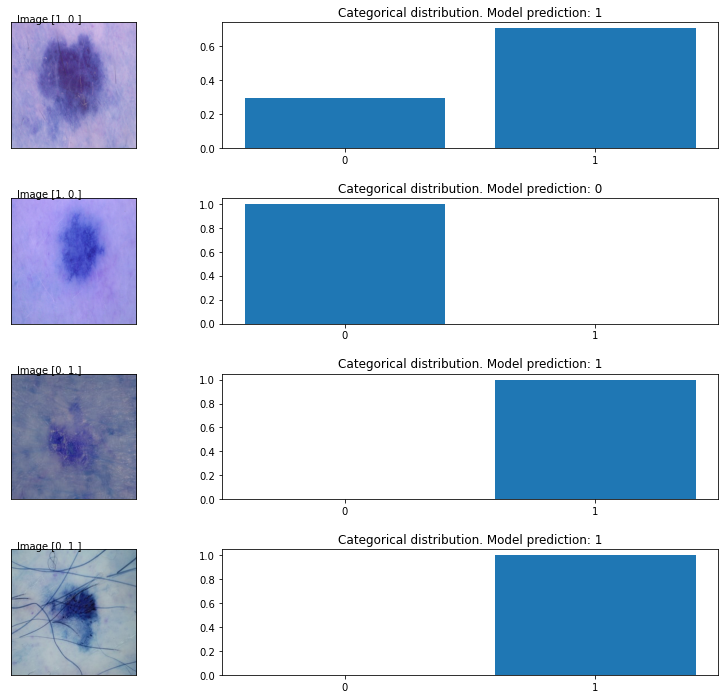

In [35]:
# Run this cell to get model predictions on randomly selected test images

num_test_images = X_test.shape[0]

random_inx = np.random.choice(num_test_images,4)
random_test_images = X_test[random_inx, ...]
random_test_labels = y_test[random_inx, ...]

predictions = model.predict(random_test_images)

fig, axes = plt.subplots(4, 2, figsize=(16, 12))
fig.subplots_adjust(hspace=0.4, wspace=-0.2)

for i, (prediction, image, label) in enumerate(zip(predictions, random_test_images, random_test_labels)):
    axes[i, 0].imshow(np.squeeze(image))
    axes[i, 0].get_xaxis().set_visible(False)
    axes[i, 0].get_yaxis().set_visible(False)
    axes[i, 0].text(10., -1.5, f'Image {label}')
    axes[i, 1].bar(np.arange(len(prediction)), prediction)
    axes[i, 1].set_xticks(np.arange(len(prediction)))
    axes[i, 1].set_title(f"Categorical distribution. Model prediction: {np.argmax(prediction)}")
    
plt.show()

### Constructing MOBILENET MODEL

In [120]:
import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
import tensorflow as tf
import imageio

In [121]:
skin_dataset_path = Path("/kaggle/input/skin-cancer-malignant-vs-benign")
skin_images = list(skin_dataset_path.glob(r'**/*.jpg'))
skin_labels = [x.parents[0].stem for x in skin_images]

In [122]:
skin_images = pd.Series(skin_images, name="Images").astype(str)
skin_labels = pd.Series(skin_labels, name="Labels").astype(str)

skin_data = pd.concat([skin_images, skin_labels], axis=1)
skin_data = skin_data.sample(frac = 1, random_state=42).reset_index(drop = True)
skin_data.head()

Images     Labels
0  /kaggle/input/skin-cancer-malignant-vs-benign/...  malignant
1  /kaggle/input/skin-cancer-malignant-vs-benign/...  malignant
2  /kaggle/input/skin-cancer-malignant-vs-benign/...     benign
3  /kaggle/input/skin-cancer-malignant-vs-benign/...  malignant
4  /kaggle/input/skin-cancer-malignant-vs-benign/...  malignant

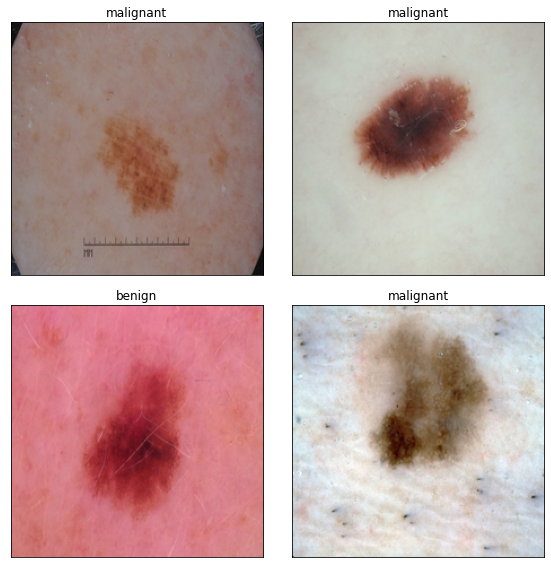

In [38]:
fig, axes = plt.subplots(2, 2, figsize=(8,8))
for i, ax in enumerate(axes.flat):
    ax.imshow(imageio.imread(skin_data.Images[i]))
    ax.set_title(skin_data.Labels[i])
    ax.set_xticks([])
    ax.set_yticks([])
plt.tight_layout()
plt.show()

## Data Augmentations
> For MobileNets the input image size used is (224, 224, 3)

- Horizontal Flipping
- Shearing
- Scaling
- Translation
- Rotation
- Brightness Shift

In [123]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import mobilenet

train_generator_mobile_net = ImageDataGenerator(
    preprocessing_function = mobilenet.preprocess_input,
    validation_split = 0.1
)

test_generator_mobile_net = ImageDataGenerator(
    preprocessing_function = mobilenet.preprocess_input
)

In [157]:
from sklearn.model_selection import train_test_split

train_df, test_df = train_test_split(skin_data, train_size=0.7, shuffle=True, random_state=42, stratify=skin_data[["Labels"]])

train = train_generator_mobile_net.flow_from_dataframe(
    dataframe=train_df,
    x_col="Images",
    y_col="Labels",
    target_size=(224, 224),
    color_mode="rgb",
    class_mode="categorical",
    batch_size=32,
    shuffle=True,
    seed=42,
    subset='training',
    rotation_range=32,
    zoom_range=0.2,
    width_shift_range=0.2,
    height_shift_range=0.2,
    sheer_range=0.2,
    horizontal_flip=True,
    brightness_range=[0.5,1.5],
    fill_mode="nearest"
)

validation = train_generator_mobile_net.flow_from_dataframe(
    dataframe=train_df,
    x_col="Images",
    y_col="Labels",
    target_size=(224, 224),
    color_mode="rgb",
    class_mode="categorical",
    batch_size=32,
    shuffle=True,
    seed=42,
    subset='validation',
    rotation_range=32,
    zoom_range=0.2,
    width_shift_range=0.2,
    height_shift_range=0.2,
    sheer_range=0.2,
    horizontal_flip=True,
    brightness_range=[0.5,1.5],
    fill_mode="nearest"
)

test = test_generator_mobile_net.flow_from_dataframe(
    dataframe=test_df,
    x_col="Images",
    y_col="Labels",
    target_size=(224, 224),
    color_mode="rgb",
    class_mode="categorical",
    batch_size=32,
    rotation_range=32,
    zoom_range=0.2,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shuffle=False
)

Found 4154 validated image filenames belonging to 2 classes.
Found 461 validated image filenames belonging to 2 classes.
Found 1979 validated image filenames belonging to 2 classes.


# Building the Model

## [MobileNet](https://arxiv.org/abs/1704.04861)

The MobileNet model is TensorFlow's first mobile computer vision model, and as the name
suggests, it is created to be utilized in mobile applications. Depth-wise separable convolutions
are used by MobileNet[109]. When compared to a network with conventional convolutions of
the same depth in the nets, it dramatically decreases the number of parameters. Light deep neural
networks are the outcome of this. We have a good starting point for training insanely tiny and
fast classifiers since MobileNet is a kind of CNN that Google open-sourced. 

MobileNets are based on a streamlined architecture that uses depth-wise separable convolutions to build light weight deep neural networks. This reduces the number of parameters needed and the corresponding computation in convolution and learning. Each convolution operation is seprated into a depthwise convolution (doesn't affect the number of channels) and a pointwise convolution (doesn't affect the size of each channel). The main difference between 2D convolutions and Depthwise Convolution is that 2D convolutions are performed over all/multiple input channels, whereas in Depthwise convolution, each channel is kept separate.

In [41]:
import tensorflow as tf

In [42]:
#using MobileNet

from tensorflow.keras.applications import mobilenet

mobilenet_ = mobilenet.MobileNet(
    input_shape=(224, 224, 3),
    include_top=False,
    alpha=1.0,
    weights='imagenet',
    pooling='avg'
)

mobilenet_.trainable = False

17235968/17225924 [==============================] - 0s 0us/step


In [43]:
CHECKPOINTS = Path("./checkpoints")
CHECKPOINTS.mkdir(exist_ok=True)

In [47]:
from tensorflow.keras.layers import Dense
from tensorflow.keras import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.metrics import CategoricalAccuracy

# building the Predictor layers
x = Dense(128, activation='relu')(mobilenet_.output)
x = Dense(256, activation='relu')(x)
x = Dense(128, activation='relu')(x)

outputs = Dense(2, activation='softmax')(x)

mobilenet = Model(inputs=mobilenet_.inputs, outputs=outputs)

mobilenet.compile(
    optimizer=Adam(),
    loss=CategoricalCrossentropy(),
    metrics=[CategoricalAccuracy()]
)

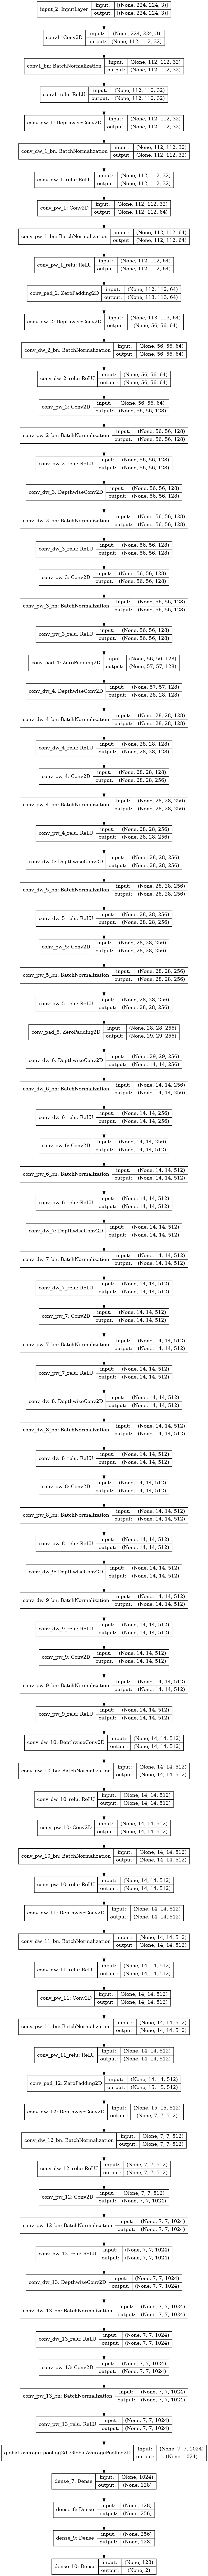

In [48]:
from tensorflow.keras.utils import to_categorical, plot_model
plot_model(mobilenet, to_file='MOBILENET_Skin_Cancer_Image.png', show_shapes=True)

In [45]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import tensorflow as tf

print("--> Checking for physical Tensorflow devices")
for device in tf.config.list_physical_devices():
    print(": {}".format(device.name))

--> Checking for physical Tensorflow devices
: /physical_device:CPU:0
: /physical_device:GPU:0


In [49]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

with tf.device('/GPU:0'):
# training
    results = mobilenet.fit(
        train,
        validation_data = validation,
        batch_size = 32,
        epochs = 50,
        callbacks = [EarlyStopping(
            monitor="val_loss",
            patience=4,
            restore_best_weights=True
        ), ReduceLROnPlateau(patience=2)]
    )

Epoch 1/50
130/130 [==============================] - 19s 138ms/step - loss: 0.3780 - categorical_accuracy: 0.8293 - val_loss: 0.2863 - val_categorical_accuracy: 0.8633
Epoch 2/50
130/130 [==============================] - 15s 113ms/step - loss: 0.2720 - categorical_accuracy: 0.8796 - val_loss: 0.2936 - val_categorical_accuracy: 0.8655
Epoch 3/50
130/130 [==============================] - 14s 111ms/step - loss: 0.2298 - categorical_accuracy: 0.8996 - val_loss: 0.2346 - val_categorical_accuracy: 0.9024
Epoch 4/50
130/130 [==============================] - 15s 112ms/step - loss: 0.0182 - categorical_accuracy: 0.9952 - val_loss: 0.2230 - val_categorical_accuracy: 0.9414
Epoch 12/50
130/130 [==============================] - 14s 111ms/step - loss: 0.0148 - categorical_accuracy: 0.9969 - val_loss: 0.2340 - val_categorical_accuracy: 0.9436
Epoch 13/50
130/130 [==============================] - 15s 113ms/step - loss: 0.0119 - categorical_accuracy: 0.9969 - val_loss: 0.2319 - val_categorical_a

In [50]:
mobilenet.save('jomi_mobilenet.h5')

In [51]:
# Testing the model
results = mobilenet.evaluate(test)

62/62 [==============================] - 7s 114ms/step - loss: 0.2422 - categorical_accuracy: 0.9363


In [52]:
predictions = np.argmax(mobilenet.predict(test), axis=1)

In [53]:
from sklearn.metrics import classification_report
labels = dict((v, k) for k, v in train.class_indices.items())
actual = list(test_df.Labels)
predictions = [labels[i] for i in predictions]
print(classification_report(actual, predictions))

              precision    recall  f1-score   support

      benign       0.94      0.94      0.94      1080
   malignant       0.93      0.93      0.93       899

    accuracy                           0.94      1979
   macro avg       0.94      0.94      0.94      1979
weighted avg       0.94      0.94      0.94      1979



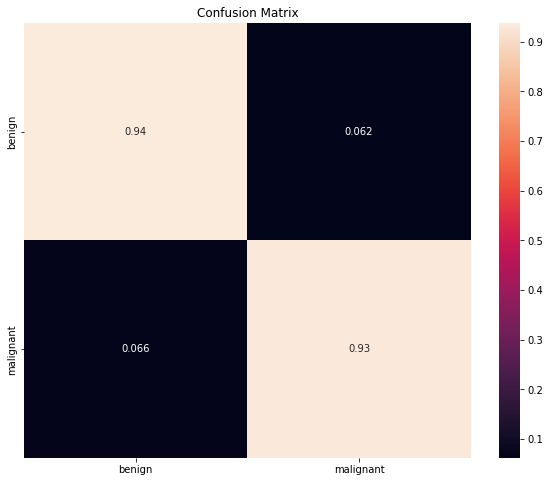

In [54]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
cf = confusion_matrix(actual, predictions, normalize = "true")
plt.figure(figsize=(10, 8))
sns.heatmap(cf, annot=True, xticklabels = sorted(set(actual)), yticklabels = sorted(set(actual)))
plt.title('Confusion Matrix')
plt.show()

## Constructing ResNet Model

In [57]:
from tensorflow.keras.applications.resnet50 import ResNet50

In [61]:
resnet_ = ResNet50(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet',
    pooling='avg'
)

resnet_.trainable = False

In [64]:
from tensorflow.keras.layers import Dense
from tensorflow.keras import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.metrics import CategoricalAccuracy

# building the Predictor layers
x = Dense(128, activation='relu')(resnet_.output)
x = Dense(256, activation='relu')(x)
x = Dense(128, activation='relu')(x)

outputs = Dense(2, activation='softmax')(x)

resnet = Model(inputs=resnet_.inputs, outputs=outputs)

resnet.compile(
    optimizer=Adam(),
    loss=CategoricalCrossentropy(),
    metrics=[CategoricalAccuracy()])

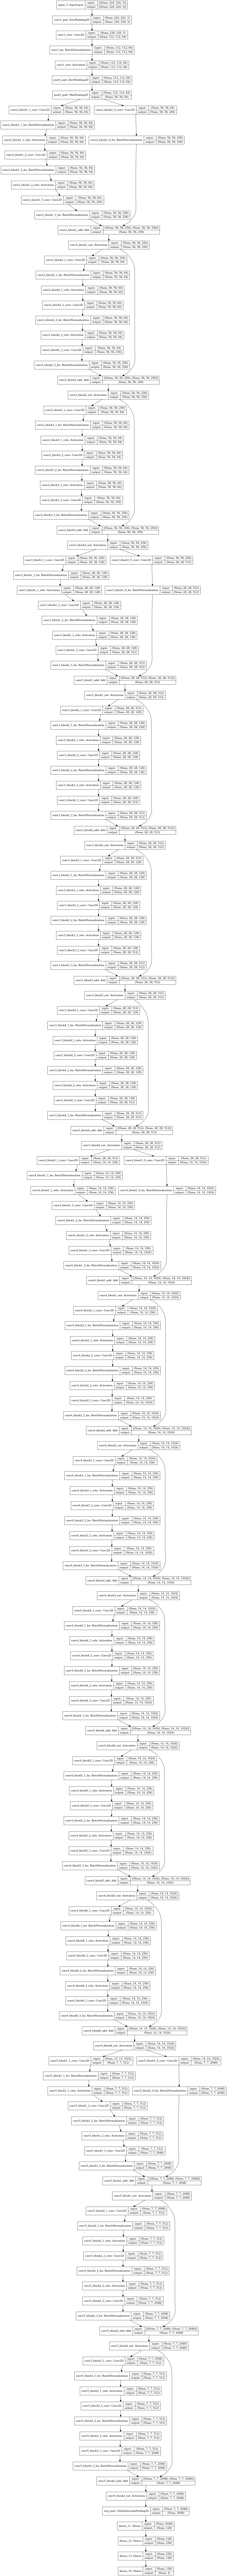

In [65]:
from tensorflow.keras.utils import to_categorical, plot_model
plot_model(resnet, to_file='RESNET_Skin_Cancer_Image.png', show_shapes=True)

In [66]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

with tf.device('/GPU:0'):
# training
    results = resnet.fit(
        train,
        validation_data = validation,
        batch_size = 32,
        epochs = 50,
        callbacks = [EarlyStopping(
            monitor="val_loss",
            patience=4,
            restore_best_weights=True
        ), ReduceLROnPlateau(patience=2)]
    )

Epoch 1/50
130/130 [==============================] - 33s 144ms/step - loss: 0.6558 - categorical_accuracy: 0.6086 - val_loss: 0.5247 - val_categorical_accuracy: 0.7223
Epoch 2/50
130/130 [==============================] - 16s 125ms/step - loss: 0.5584 - categorical_accuracy: 0.7087 - val_loss: 0.5189 - val_categorical_accuracy: 0.7267
Epoch 3/50
130/130 [==============================] - 16s 123ms/step - loss: 0.5125 - categorical_accuracy: 0.7511 - val_loss: 0.4126 - val_categorical_accuracy: 0.8265
Epoch 4/50
130/130 [==============================] - 16s 122ms/step - loss: 0.4844 - categorical_accuracy: 0.7619 - val_loss: 0.4866 - val_categorical_accuracy: 0.8113
Epoch 5/50
130/130 [==============================] - 16s 122ms/step - loss: 0.4886 - categorical_accuracy: 0.7605 - val_loss: 0.3875 - val_categorical_accuracy: 0.8243
Epoch 6/50
130/130 [==============================] - 16s 124ms/step - loss: 0.4393 - categorical_accuracy: 0.7877 - val_loss: 0.4579 - val_categorical_acc

In [147]:
resnet.save('jomi_resnet.h5')
results = resnet.evaluate(test)
predictions = np.argmax(resnet.predict(test), axis=1)
from sklearn.metrics import classification_report
labels = dict((v, k) for k, v in train.class_indices.items())
actual = list(test_df.Labels)
predictions = [labels[i] for i in predictions]
print(classification_report(actual, predictions))

/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


62/62 [==============================] - 7s 109ms/step - loss: 0.3885 - categorical_accuracy: 0.8125
              precision    recall  f1-score   support

      benign       0.90      0.74      0.81      1080
   malignant       0.74      0.90      0.81       899

    accuracy                           0.81      1979
   macro avg       0.82      0.82      0.81      1979
weighted avg       0.83      0.81      0.81      1979



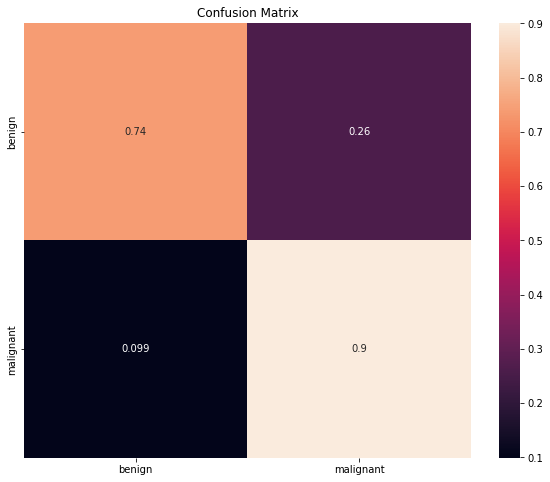

In [70]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
cf = confusion_matrix(actual, predictions, normalize = "true")
plt.figure(figsize=(10, 8))
sns.heatmap(cf, annot=True, xticklabels = sorted(set(actual)), yticklabels = sorted(set(actual)))
plt.title('Confusion Matrix')
plt.show()

### Comparative Analysis

In [130]:
from keras.models import load_model
from sklearn. metrics import f1_score,classification_report, accuracy_score, precision_score, recall_score

In [158]:
cnnModel = load_model('CNN_Model2.h5')
mobileModel = load_model('jomi_mobilenet.h5')
resModel = load_model('jomi_resnet.h5')
models = [cnnModel, mobileModel,resModel]

In [159]:
def evaluateModel(models, y_scores):
    # Get evaluation metrics
    predictions = [np.argmax(model.predict(test ),axis = 1) for model in models]
    
    def getMetrics(y_test, predictions):
        acc = accuracy_score(y_test, predictions)
        rec = recall_score(y_test, predictions)
        pre = precision_score(y_test, predictions)
        f1 = f1_score(y_test, predictions)
        return([acc,rec,pre,f1])
    
    cnn_results = getMetrics(y_scores, predictions[0])
    mobilenet_results = getMetrics(y_scores, predictions[1])
    resnet_results = getMetrics(y_scores, predictions[2])
    print('============================================')
    
    ##Create Comparison DataFrame
    index = ['Accuracy', 'Recall', 'Precision', 'F1_score']
    data = {'CNN': cnn_results,
           'MOBILENET': mobilenet_results, 
            'RESNET':resnet_results
           } 
    results_df = pd.DataFrame(data = data, index = index)
    return results_df

In [161]:
actual1 = [1 if i == 'malignant' else 0 for i in actual]
evaluateModel(models,actual1)

CNN  MOBILENET    RESNET
Accuracy   0.449217   0.936331  0.812532
Recall     0.929922   0.934372  0.901001
Precision  0.448739   0.926130  0.741758
F1_score   0.605358   0.930233  0.813661